In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [133]:
import os

# Set the environment variable OMP_NUM_THREADS to 1
os.environ["OMP_NUM_THREADS"] = "1"

from sklearn.cluster import KMeans

In [134]:
views_en = pd.read_csv('data/Philo_en.csv')
views_lang = pd.read_csv('data/Philos_lang.csv')

### Preprocessing 

In [135]:
# Rename rows with wrong country code 

views_lang['code'] = views_lang['project'].str.split('.').str[0]
views_en['code'] = views_en['project'].str.split('.').str[0]
views_en['subject'] = views_en['article']

In [136]:
#Filter the code to get topics present in all language 
article_counts = views_lang.groupby('subject')['code'].nunique()
articles_to_keep = article_counts[article_counts == views_lang['code'].nunique()].index.tolist()
views_lang_filtered = views_lang[views_lang['subject'].isin(articles_to_keep)]

In [137]:
def compute_fraction_per_lang(views):
    
    grouped = views.groupby(['code', 'project'])['views'].sum()
    articles = views.groupby(['code','subject'])['views'].sum()

    grouped = grouped.to_frame(name='views_count_by_language').reset_index()
    articles = articles.to_frame(name='views_count_by_article').reset_index()

    merged_df = pd.merge(articles, grouped[['code','views_count_by_language']], on='code', how='left')
    merged_df['fraction_of_views'] = merged_df['views_count_by_article'] / merged_df['views_count_by_language']
    
    return merged_df

In [138]:
def compute_cluster(fraction_views, nb_cluster) : 
    fraction_views_clustered = fraction_views.copy()
    kmeans = KMeans(nb_cluster, n_init= 10)
    kmeans.fit(fraction_views_clustered)
    fraction_views_clustered = kmeans.labels_
    return fraction_views_clustered

In [139]:
fraction_views_lang = compute_fraction_per_lang(views_lang_filtered)
#fraction_views_en = compute_fraction_per_lang(views_en)

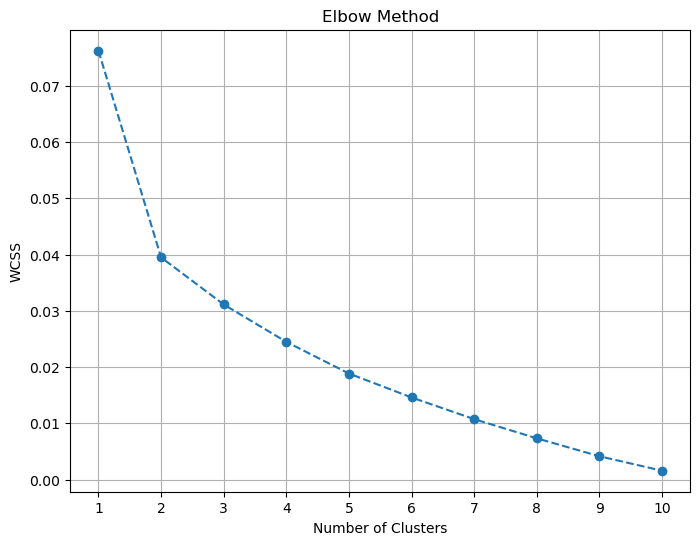

In [140]:
wcss = []

# Arr is a matrix of fraction of views per language per article for each country
arr = np.vstack(fraction_views_lang.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)

for i in range(1, 11):  # Trying different numbers of clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init= 10)
    kmeans.fit(arr)
    wcss.append(kmeans.inertia_)  # Inertia is the within-cluster sum of squares

# Plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, 11, 1))  # Setting x-axis ticks from 1 to 10
plt.grid()

In [239]:
NB_CLUSTER = 2

arr = np.vstack(fraction_views_lang.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)
clusters = compute_cluster(arr, NB_CLUSTER)
lang_clusters = pd.DataFrame({'Cluster_Labels': clusters, 'Country_Codes': fraction_views_lang['code'].unique()})

for cluster_label, group in lang_clusters.groupby('Cluster_Labels'):
    country_names = ', '.join(group['Country_Codes'])
    print(f'Cluster {cluster_label}: {country_names}')

Cluster 0: da, fi, ko, nl, no, sr, sv
Cluster 1: de, fr, it, ja


## Same but for each period

In [142]:
interventions = pd.read_csv('data/interventions.csv')
interventions = interventions.drop(9)
interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
5,no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
6,sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
7,sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
8,ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15
10,fi,2020-01-29,2020-03-21,2020-03-16,2020-03-16,NaN,2020-03-16,2020-05-21


In [143]:
interventions_thresholds = interventions.copy(deep=True)

interventions_thresholds['Mobility'] = pd.to_datetime(interventions_thresholds['Mobility'])
interventions_thresholds['Normalcy'] = pd.to_datetime(interventions_thresholds['Normalcy'])

interventions_thresholds['Mobility']  = interventions_thresholds['Mobility'].dt.strftime('%Y%m%d').astype('int64')
interventions_thresholds['Normalcy']  = interventions_thresholds['Normalcy'].dt.strftime('%Y%m%d').astype('int64')

interventions_thresholds['Mobility'] = interventions_thresholds['Mobility'].astype(str) + '00'
interventions_thresholds['Mobility'] = interventions_thresholds['Mobility'].astype(int)

interventions_thresholds['Normalcy'] = interventions_thresholds['Normalcy'].astype(str) + '00'
interventions_thresholds['Normalcy'] = interventions_thresholds['Normalcy'].astype(int)

threshold_date_before = interventions_thresholds[['lang','Mobility']]
threshold_date_after = interventions_thresholds[['lang','Normalcy']]

threshold_date_before.set_index('lang', inplace=True)
threshold_date_after.set_index('lang', inplace=True)

threshold_date_before = threshold_date_before.squeeze()
threshold_date_after = threshold_date_after.squeeze()

In [ ]:
mean_fraction_logs = views_lang.groupby(['subject', 'code'])['fraction_of_logs'].mean().reset_index()


In [155]:
codes = views_lang['code'].unique()
before_threshold_all = pd.DataFrame()
between_thresholds_all = pd.DataFrame()
after_threshold_all = pd.DataFrame()

for code in codes : 

    lang_rows = views_lang[views_lang['code'] == code]

    before_threshold = lang_rows[lang_rows['timestamp'] < threshold_date_before.loc[code]]
    between_thresholds = lang_rows[(lang_rows['timestamp'] >= threshold_date_before.loc[code]) & (lang_rows['timestamp'] <= threshold_date_after.loc[code])]
    after_threshold = lang_rows[lang_rows['timestamp'] > threshold_date_after.loc[code]]

    before_threshold_all = pd.concat([before_threshold_all, before_threshold])
    between_thresholds_all = pd.concat([between_thresholds_all, between_thresholds])
    after_threshold_all = pd.concat([after_threshold_all, after_threshold])

In [156]:
#Filter the code to get topics present in all language 

article_counts = before_threshold_all.groupby('subject')['code'].nunique()
articles_to_keep = article_counts[article_counts == before_threshold_all['code'].nunique()].index.tolist()
before_threshold_all_filtered = before_threshold_all[before_threshold_all['subject'].isin(articles_to_keep)]

article_counts = between_thresholds_all.groupby('subject')['code'].nunique()
articles_to_keep = article_counts[article_counts == between_thresholds_all['code'].nunique()].index.tolist()
between_thresholds_all_filtered = between_thresholds_all[between_thresholds_all['subject'].isin(articles_to_keep)]

article_counts = after_threshold_all.groupby('subject')['code'].nunique()
articles_to_keep = article_counts[article_counts == after_threshold_all['code'].nunique()].index.tolist()
after_threshold_all_filtered = after_threshold_all[after_threshold_all['subject'].isin(articles_to_keep)]

In [249]:
fraction_views_lang_before = compute_fraction_per_lang(before_threshold_all_filtered)
fraction_views_lang_between = compute_fraction_per_lang(between_thresholds_all_filtered)
fraction_views_lang_after = compute_fraction_per_lang(after_threshold_all_filtered)

In [297]:
def compute_fraction_per_delta_t(views):
    # Group by 'code', 'project', and 'timestamp' to get views per language per timestamp
    grouped = views.groupby(['code', 'project', 'timestamp'])['views'].sum()

    # Group by 'code', 'subject', and 'timestamp' to get views per article per timestamp
    articles = views.groupby(['code', 'subject', 'timestamp'])['views'].sum()


    grouped = grouped.to_frame(name='views_count_by_language').reset_index()
    articles = articles.to_frame(name='views_count_by_article').reset_index()

    # Merge the two DataFrames on 'code' and 'timestamp'
    #merged_df = pd.merge(articles, grouped[['code', 'timestamp', 'views']], on=['code', 'timestamp'], how='left')

    # Rename the columns
    #merged_df = merged_df.rename(columns={'views_x': 'views_count_by_article', 'views_y': 'views_count_by_language'})

    # Calculate the fraction of views for each date
    #merged_df['fraction_of_views'] = merged_df['views_count_by_article'] / merged_df.groupby(['code', 'timestamp'])['views_count_by_language'].transform('sum')

    merged_df = pd.merge(articles, grouped[['timestamp','code','views_count_by_language']], on=['timestamp', 'code'], how='left')
    merged_df['fraction_of_views'] = merged_df['views_count_by_article'] / merged_df['views_count_by_language']
    
    return merged_df

In [298]:
fraction_views_lang_before_delta_t = compute_fraction_per_delta_t(before_threshold_all_filtered)

In [300]:
mean_fraction_logs = fraction_views_lang_before_delta_t.groupby(['subject', 'code'])['fraction_of_views'].mean().reset_index()
fraction_of_logs_df = pd.merge(fraction_views_lang_before, mean_fraction_logs, on=['subject', 'code'], suffixes=('', '_mean'))

fraction_of_logs_df['adjusted_fraction_of_logs'] = fraction_of_logs_df['fraction_of_views'] - fraction_of_logs_df['fraction_of_views_mean']


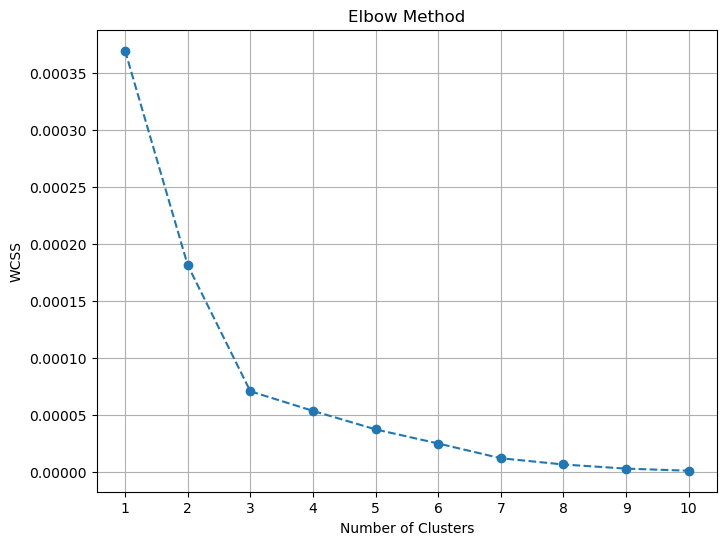

In [303]:
wcss = []

# Arr is a matrix of fraction of views per language per article for each country
arr = np.vstack(fraction_of_logs_df.groupby('code')['adjusted_fraction_of_logs'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)

for i in range(1, 11):  # Trying different numbers of clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init= 10)
    kmeans.fit(arr)
    wcss.append(kmeans.inertia_)  # Inertia is the within-cluster sum of squares

# Plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, 11, 1))  # Setting x-axis ticks from 1 to 10
plt.grid()

In [313]:
NB_CLUSTER = 3

arr = np.vstack(fraction_of_logs_df.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)
clusters = compute_cluster(arr, NB_CLUSTER)
lang_clusters = pd.DataFrame({'Cluster_Labels': clusters, 'Country_Codes': fraction_of_logs_df['code'].unique()})

for cluster_label, group in lang_clusters.groupby('Cluster_Labels'):
    country_names = ', '.join(group['Country_Codes'])
    print(f'Cluster {cluster_label}: {country_names}')

Cluster 0: da, nl
Cluster 1: de, fr, it, ja
Cluster 2: fi, ko, no, sr, sv


In [315]:
mean_fraction_logs = fraction_views_lang_before_delta_t.groupby(['subject', 'code'])['fraction_of_views'].mean().reset_index()
fraction_of_logs_df_between = pd.merge(fraction_views_lang_between, mean_fraction_logs, on=['subject', 'code'], suffixes=('', '_mean'))

fraction_of_logs_df_between['adjusted_fraction_of_logs'] = fraction_of_logs_df_between['fraction_of_views'] - fraction_of_logs_df_between['fraction_of_views_mean']


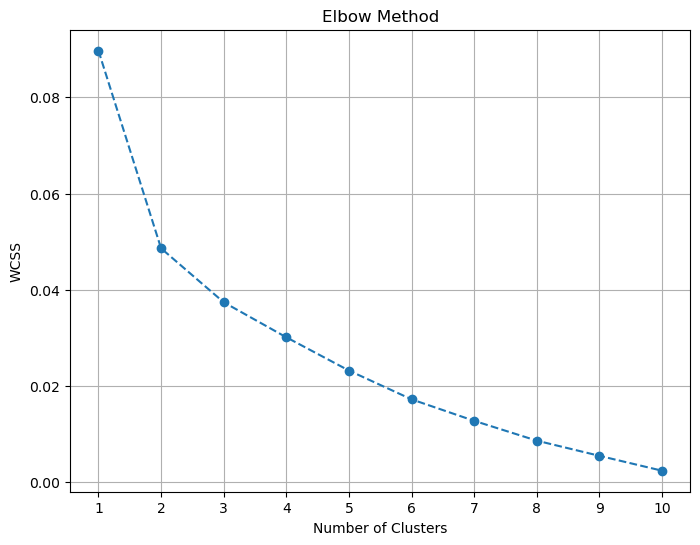

In [317]:
wcss = []

# Arr is a matrix of fraction of views per language per article for each country
arr = np.vstack(fraction_of_logs_df_between.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)

for i in range(1, 11):  # Trying different numbers of clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init= 10)
    kmeans.fit(arr)
    wcss.append(kmeans.inertia_)  # Inertia is the within-cluster sum of squares

# Plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, 11, 1))  # Setting x-axis ticks from 1 to 10
plt.grid()

In [319]:
NB_CLUSTER = 2

arr = np.vstack(fraction_of_logs_df_between.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)
clusters = compute_cluster(arr, NB_CLUSTER)
lang_clusters = pd.DataFrame({'Cluster_Labels': clusters, 'Country_Codes': fraction_of_logs_df_between['code'].unique()})

for cluster_label, group in lang_clusters.groupby('Cluster_Labels'):
    country_names = ', '.join(group['Country_Codes'])
    print(f'Cluster {cluster_label}: {country_names}')

Cluster 0: de, fr, it, ja
Cluster 1: da, fi, ko, nl, no, sr, sv


In [320]:
mean_fraction_logs = fraction_views_lang_before_delta_t.groupby(['subject', 'code'])['fraction_of_views'].mean().reset_index()
fraction_of_logs_df_after = pd.merge(fraction_views_lang_between, mean_fraction_logs, on=['subject', 'code'], suffixes=('', '_mean'))

fraction_of_logs_df_after['adjusted_fraction_of_logs'] = fraction_of_logs_df_after['fraction_of_views'] - fraction_of_logs_df_after['fraction_of_views_mean']


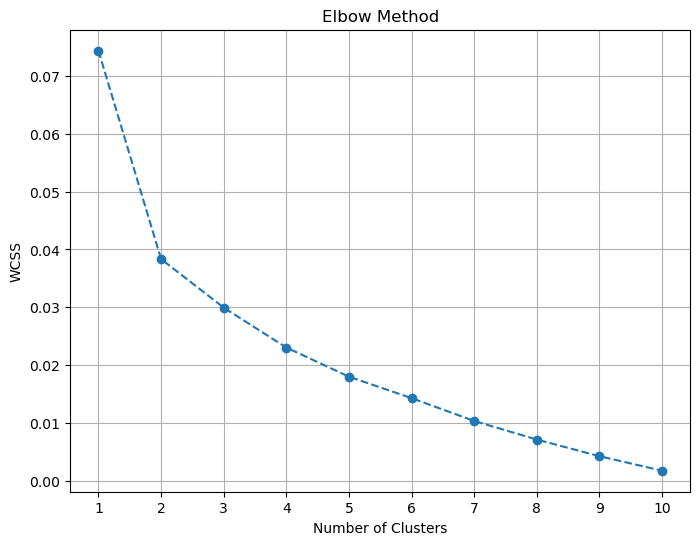

In [321]:
wcss = []

# Arr is a matrix of fraction of views per language per article for each country
arr = np.vstack(fraction_views_lang_after.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)

for i in range(1, 11):  # Trying different numbers of clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init= 10)
    kmeans.fit(arr)
    wcss.append(kmeans.inertia_)  # Inertia is the within-cluster sum of squares

# Plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, 11, 1))  # Setting x-axis ticks from 1 to 10
plt.grid()

In [325]:
NB_CLUSTER = 2

arr = np.vstack(fraction_of_logs_df_after.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)
clusters = compute_cluster(arr, NB_CLUSTER)
lang_clusters = pd.DataFrame({'Cluster_Labels': clusters, 'Country_Codes': fraction_of_logs_df_after['code'].unique()})

for cluster_label, group in lang_clusters.groupby('Cluster_Labels'):
    country_names = ', '.join(group['Country_Codes'])
    print(f'Cluster {cluster_label}: {country_names}')

Cluster 0: de, fr, it, ja
Cluster 1: da, fi, ko, nl, no, sr, sv


In [166]:
fraction_views_lang_not_filtered = compute_fraction_per_lang(views_lang)

In [167]:
fraction_views_lang_not_filtered

,code,subject,views_count_by_article,views_count_by_language,fraction_of_views
0,da,Absurdism,9243,6250540,0.001479
1,da,Actual idealism,74176,6250540,0.011867
2,da,Actualism,2960,6250540,0.000474
3,da,Aesthetic Realism,169572,6250540,0.027129
4,da,Aesthetics,80658,6250540,0.012904
...,...,...,...,...,...
2232,sv,Philosophy of motion,15186,17418050,0.000872
2233,sv,Philosophy of music,7440,17418050,0.000427
2234,sv,School of Names,134680,17418050,0.007732
2235,sv,School of Naturalists,46765,17418050,0.002685


In [200]:
grouped = fraction_views_lang_not_filtered.groupby(['subject', 'code'])

# Step 2: Compute the count of unique languages for each page
#page_language_count = grouped.size().reset_index(name='language_count')
article_languages_count = views_lang.groupby('subject')['code'].nunique() 

# Step 3: Filter pages based on the count of unique languages
threshold_unique_languages = 11  # Adjust as needed
filtered_pages = article_languages_count[article_languages_count < threshold_unique_languages]

# Step 4: Apply a threshold filter to select pages with logs above a certain threshold
threshold_log_count = 0.05  # Adjust as needed
final_result = fraction_views_lang_not_filtered[fraction_views_lang_not_filtered['subject'].isin(filtered_pages.index) & (fraction_views_lang_not_filtered['fraction_of_views'] > threshold_log_count)]

final_result

,code,subject,views_count_by_article,views_count_by_language,fraction_of_views
223,de,Continental philosophy,4864971,88900800,0.054724
574,fi,Philosophy of artificial intelligence,743808,14018637,0.053059


In [192]:
article_languages_count = views_lang.groupby('subject')['code'].nunique() 

In [194]:
article_languages_count[article_languages_count > threshold_unique_languages]

subject
Absurdism                   11
Actual idealism              9
Actualism                    8
Advaita Vedanta              8
Aesthetic Realism           10
                            ..
Philosophy of music         10
School of Names             11
School of Naturalists       11
The Philosophy of Chance    11
Western esotericism          7
Name: code, Length: 237, dtype: int64